# Lab Seminar 4: Extracting Insights from the Topology of UAAP Player Statistics

### Ang, Pino, Rosario | January 31, 2024

# Applying the Mapper algorithm to UAAP Data using giotto-tda

## Introduction to giotto-tda

giotto-tda [1] is a high-performance library for topological data analysis and topological machine learning in Python. During our last presentation, we were recommended this library over our previous implementation tools, and we agree on its advantages. The features of interest to our paper are the following:

* Complete feature set: giotto-tda provides implementations for many topological data analysis techniques, including both Persistent Homology using Vietoris-Rips persistence, and the Mapper algorithm. Therefore, we hope be able to unify our methodology using one common library rather than a separate library for each technique.

* Integration with scikit-learn: giotto-tda is compatible with sklearn functions such as PCA and DBSCAN, as well as using a similar pipeline object further making it more convenient to code, especially anticipating future Machine Learning applications.

* Mapper Interactive Plotter: this feature allows us to conveniently test different hyperparameters for using the Mapper algorithm on our data.


[1] giotto-tda: A Topological Data Analysis Toolkit for Machine Learning and Data Exploration, Tauzin et al, J. Mach. Learn. Res. 22.39 (2021): 1-6.

## Mapper algorithm

### Import libraries

In [ ]:
# # Setup venv
# %pip install pandas
# %pip install giotto-tda
# %pip install scikit-learn
# %pip install matplotlib

In [2]:
# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module

# Data viz
from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import sklearn as sk
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('../data/stats_fix.csv')
df.head(5)

,Number,Name,Team,Position,PPG,RPG,APG,SPG,BPG,TOPG,...,DEF REBOUNDS,OFF REBOUNDS,AST,STL,BLK,OFF TOs,DEF TOs,TECH,UF,TOTAL
0,10,"Ildefonso, Dave",ADMU,G,12.0,8.3,2.7,1.0,0.1,2.8,...,85,31,37,16,1,1,23,0,0,24
1,34,"Kouame, Ange",ADMU,C,11.6,11.3,1.7,0.5,2.5,1.4,...,84,76,25,7,36,1,34,0,1,36
2,2,"Andrade, Bryan",ADMU,G,9.5,2.7,2.1,0.9,0.2,1.5,...,26,13,30,13,3,1,21,0,0,22
3,6,"Koon, Chris",ADMU,G,6.3,3.4,1.9,0.7,0.1,1.3,...,39,10,23,11,2,1,13,0,1,15
4,13,"Gomez, Vince",ADMU,G,3.4,0.7,2.0,0.5,0.0,1.3,...,5,1,25,6,0,0,14,0,0,14


### Processing (todo: bake into csv)

In [8]:
dicti = {'G': 1, 'F': 2, 'C' : 3, np.nan: 4}
invdict = {v: k for k, v in dicti.items()}
positions = list(df['Position'])
# print(positions)

position_labels = [dicti[x] for x in positions]
len(position_labels)

129

In [11]:

df_numVar = df.select_dtypes(include=['number']).drop('Number', axis=1)
df_numVar.head(5)

,PPG,RPG,APG,SPG,BPG,TOPG,FPG,FDPG,+/-,EFFPG,...,DEF REBOUNDS,OFF REBOUNDS,AST,STL,BLK,OFF TOs,DEF TOs,TECH,UF,TOTAL
0,12.0,8.3,2.7,1.0,0.1,2.8,1.7,2.3,7.7,13.5,...,85,31,37,16,1,1,23,0,0,24
1,11.6,11.3,1.7,0.5,2.5,1.4,2.4,3.9,8.7,24.7,...,84,76,25,7,36,1,34,0,1,36
2,9.5,2.7,2.1,0.9,0.2,1.5,1.5,1.8,9.9,10.3,...,26,13,30,13,3,1,21,0,0,22
3,6.3,3.4,1.9,0.7,0.1,1.3,1.2,1.5,2.7,9.2,...,39,10,23,11,2,1,13,0,1,15
4,3.4,0.7,2.0,0.5,0.0,1.3,1.2,1.0,-1.1,3.4,...,5,1,25,6,0,0,14,0,0,14


### PCA

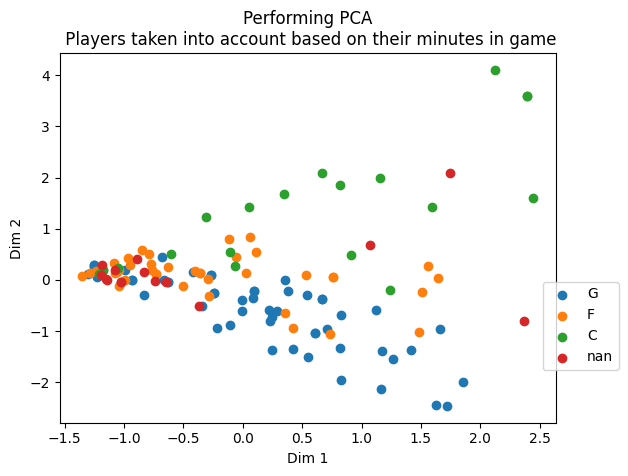

In [12]:
auxnames = ['RPG','AST','TOPG','STL','BLK','TOTAL','PPG']
df_final = df_numVar[auxnames]

df_scaled = sk.preprocessing.scale(df_final)
pca = sk.decomposition.PCA(n_components=3, whiten=True)
df_red = pca.fit_transform(df_scaled)

statesN = [1,2,3,4]
states = [invdict[x] for x in statesN]
states

import matplotlib.patches as mpatches
pylab.title("Performing PCA\n Players taken into account based on their minutes in game")
pylab.xlabel("Dim 1")
pylab.ylabel("Dim 2")
#pylab.scatter(df_red[:, 0], df_red[:, 1], c=position_labels)

states = [invdict[x] for x in [1,2,3,4]]
for i,l in enumerate(states):
    x = []
    y = []
    for j,_ in enumerate(df_red[:, 0]):
        if position_labels[j] == i+1:
            x.append(df_red[j,0])
            y.append(df_red[j,1])
    pylab.scatter(x,y,label=l)

pylab.legend(loc='upper center', bbox_to_anchor=(1.05, .4) ,scatterpoints = 1)
pylab.show()

In [13]:
filterDim1 = pd.Series(df_red[:,0], name='Dim1')
filterDim2 = pd.Series(df_red[:,1], name='Dim2')
df_withFilter = pd.concat([filterDim1,filterDim2,df_final],axis=1)
#print df_withFilter 
df_withFilter.head(5)

,Dim1,Dim2,RPG,AST,TOPG,STL,BLK,TOTAL,PPG
0,1.660944,-0.963583,8.3,37,2.8,16,1,24,12.0
1,2.122096,4.102177,11.3,25,1.4,7,36,36,11.6
2,0.706490,-0.948534,2.7,30,1.5,13,3,22,9.5
3,0.291002,-0.607717,3.4,23,1.3,11,2,15,6.3
4,-0.214059,-0.931973,0.7,25,1.3,6,0,14,3.4


## Mapper algorithm

Mapper is a way to construct a graph (or simplicial complex) from data in a way that reveals some of the topological features of the space. It consists of four general steps:

* Project a dataset into a lower-dimensional space. our implementation
* Cover this projection
* Cluster all points inside an interval
* Visual exploration

![Mapper Overview](mapper_overview.png)

### Configure the Mapper pipeline

In [14]:
# For illustration:
# Basic steps behind Mapper
# Given dataset D
# 1. Map D into a lower-dimensional space using a filter function (e.g. PCA)
from gtda.mapper.filter import Projection
from sklearn.decomposition import PCA
# 2. Construct a cover of the filter values, i.e. overlapping intervals
from gtda.mapper.cover import CubicalCover
# 3. Cluster the points in the preimage of each interval
from sklearn.cluster import DBSCAN
# 4. Construct the topological graph
# handled by MapperInteractivePlotter

In [16]:
# Define filter function – can be any scikit-learn transformer
filter_func = PCA(n_components=2)
# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

pipe

MapperPipeline(steps=[('pullback_cover',
                       ListFeatureUnion(transformer_list=[('clustering_preprocessing',
                                                           FunctionTransformer(validate=True)),
                                                          ('map_and_cover',
                                                           Pipeline(steps=[('scaler',
                                                                            FunctionTransformer()),
                                                                           ('filter_func',
                                                                            PCA(n_components=2)),
                                                                           ('cover',
                                                                            CubicalCover(overlap_frac=0.3))]))])),
                      ('clustering',
                       ParallelClustering(clusterer=DBSCAN(), n_jobs=1)),
                      ('nerve', Nerve())])

In [17]:
color_data = pd.get_dummies(df["Position"], prefix="Position")

color_data2 = position_labels

In [ ]:
# Create the plotter object
MIP = MapperInteractivePlotter(pipe, df_withFilter)

# Generate interactive widget
MIP.plot(color_data=color_data)

### Results of Interest

* A visible "hole" appears in the Mapper graph using n_intervals = 10, overlap_frac = 5. Using the position coloring, we see that this hole appears between Forwards and Centers.

* The outliers are FSAs Kouame, Faye, and Diouf, and Luis Villegas, who would go on to become No. 3 PBA Draft pick [2]. 

[2] https://www.spin.ph/basketball/pba/guiao-says-drafting-luis-villegas-after-serious-injury-is-risk-worth-taking-a795-20230921

In [11]:
MIP.graph_.vs[32]

igraph.Vertex(<igraph.Graph object at 0x000002D56F6B9040>, 32, {'pullback_set_label': 24, 'partial_cluster_label': -1, 'node_elements': array([ 61, 100])})

In [27]:
x = MIP.graph_.vs[4]["node_elements"]
members = df.iloc[x]
members

array([  2,  42,  59,  71,  73,  74,  85,  89,  99, 100, 102, 114, 119])

In [13]:
x = MIP.graph_.vs[58]["node_elements"]
members = df.iloc[x]
members

IndexError: vertex index out of range

In [14]:
x = MIP.graph_.vs[57]["node_elements"]
members = df.iloc[x]
members

IndexError: vertex index out of range

### No PCA

Instead of using the dimensions of PCA as the Projection, we attempted to use the statistics themselves. The speed of the algorithm was noticeably much slower and prevented us from testing with the parameters much.

In [15]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=['RPG','AST','TOPG','STL','BLK','TOTAL','PPG'])
# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe2 = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

pipe

filter_func

Projection(columns=['RPG', 'AST', 'TOPG', 'STL', 'BLK', 'TOTAL', 'PPG'])

In [91]:
# Create the plotter object
MIP = MapperInteractivePlotter(pipe2, df_withFilter)

# Generate interactive widget
MIP.plot(color_data=color_data)

### PCA with All Features

We try PCA using all dataset features, instead of the seven identified by M. Alagappan.

In [16]:
df_numVar = df.select_dtypes(include=['number']).drop('Number',1)
df_numVar.iloc[1]

C:\Users\PINO\AppData\Local\Temp\ipykernel_16044\2435332245.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PPG                11.60
RPG                11.30
APG                 1.70
SPG                 0.50
BPG                 2.50
TOPG                1.40
FPG                 2.40
FDPG                3.90
+/-                 8.70
EFFPG              24.70
MPG_x              27.30
GP                 14.00
MIN             23101.00
STARTS             14.00
 3PT FGs %         50.00
2PT FGs %          55.77
FGs %              55.08
DEFENDED %         50.00
OPEN %             87.50
FTs %              53.85
HI                 22.00
LO                  2.00
DEF REBOUNDS       84.00
OFF REBOUNDS       76.00
AST                25.00
STL                 7.00
BLK                36.00
OFF TOs             1.00
DEF TOs            34.00
TECH                0.00
UF                  1.00
TOTAL              36.00
Name: 1, dtype: float64

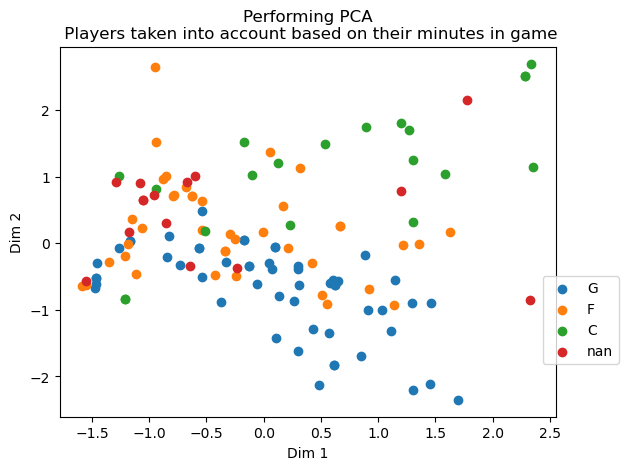

In [17]:
auxnames = ['RPG','AST','TOPG','STL','BLK','TOTAL','PPG']
df_final2 = df_numVar[auxnames]

df_scaled2 = sk.preprocessing.scale(df_numVar)
pca2 = sk.decomposition.PCA(n_components=3, whiten=True)
df_red2 = pca.fit_transform(df_scaled2)

statesN = [1,2,3,4]
states = [invdict[x] for x in statesN]
states

import matplotlib.patches as mpatches
pylab.title("Performing PCA\n Players taken into account based on their minutes in game")
pylab.xlabel("Dim 1")
pylab.ylabel("Dim 2")
#pylab.scatter(df_red[:, 0], df_red[:, 1], c=position_labels)

states = [invdict[x] for x in [1,2,3,4]]
for i,l in enumerate(states):
    x = []
    y = []
    for j,_ in enumerate(df_red2[:, 0]):
        if position_labels[j] == i+1:
            x.append(df_red2[j,0])
            y.append(df_red2[j,1])
    pylab.scatter(x,y,label=l)

pylab.legend(loc='upper center', bbox_to_anchor=(1.05, .4) ,scatterpoints = 1)
pylab.show()

In [18]:
df_red2

array([[ 1.45959423e+00, -8.91225439e-01,  4.00585762e-01],
       [ 2.33133867e+00,  2.69626968e+00, -3.76039046e-01],
       [ 9.07105845e-01, -1.00581247e+00,  1.07755559e+00],
       [ 3.00649256e-01, -3.87203346e-01,  9.28961008e-01],
       [-3.75718763e-01, -8.78677652e-01,  2.80801753e-01],
       [ 1.70555297e-01,  5.68637843e-01, -1.23385985e+00],
       [ 1.24530091e-01,  1.20657006e+00, -9.48887456e-01],
       [-9.36472280e-01,  1.52289250e+00,  2.03180038e+00],
       [-6.81055763e-01,  8.41993548e-01,  3.08314134e-01],
       [-1.45685366e+00, -2.91669886e-01, -6.98358278e-01],
       [-1.25980218e+00,  1.00599302e+00,  5.38446198e-01],
       [-1.47092332e+00, -6.72051536e-01, -1.51930184e+00],
       [ 2.27761011e+00,  2.50899737e+00, -2.90919931e+00],
       [ 2.27761011e+00,  2.50899737e+00, -2.90919931e+00],
       [ 6.21719184e-01, -6.29753283e-01, -7.70218883e-01],
       [ 6.21719184e-01, -6.29753283e-01, -7.70218883e-01],
       [-1.24020287e-01, -3.36888889e-01

In [19]:
filterDim1 = pd.Series(df_red2[:,0], name='Dim1')
filterDim2 = pd.Series(df_red2[:,1], name='Dim2')
df_allFeatures = pd.concat([filterDim1,filterDim2,df_numVar],axis=1)
df_allFeatures.head(5)

,Dim1,Dim2,PPG,RPG,APG,SPG,BPG,TOPG,FPG,FDPG,...,DEF REBOUNDS,OFF REBOUNDS,AST,STL,BLK,OFF TOs,DEF TOs,TECH,UF,TOTAL
0,1.459594,-0.891225,12.0,8.3,2.7,1.0,0.1,2.8,1.7,2.3,...,85,31,37,16,1,1,23,0,0,24
1,2.331339,2.696270,11.6,11.3,1.7,0.5,2.5,1.4,2.4,3.9,...,84,76,25,7,36,1,34,0,1,36
2,0.907106,-1.005812,9.5,2.7,2.1,0.9,0.2,1.5,1.5,1.8,...,26,13,30,13,3,1,21,0,0,22
3,0.300649,-0.387203,6.3,3.4,1.9,0.7,0.1,1.3,1.2,1.5,...,39,10,23,11,2,1,13,0,1,15
4,-0.375719,-0.878678,3.4,0.7,2.0,0.5,0.0,1.3,1.2,1.0,...,5,1,25,6,0,0,14,0,0,14


In [20]:
# Create the plotter object
MIP = MapperInteractivePlotter(pipe, df_allFeatures)

# Generate interactive widget
MIP.plot(color_data=color_data)

## Revision

In [23]:
# Use PCA as filter_func
pca_filter = sk.decomposition.PCA(n_components=2, whiten=True)

# Initialise pipeline
pipe3 = make_mapper_pipeline(
    filter_func=pca_filter,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

pipe3

MapperPipeline(steps=[('pullback_cover',
                       ListFeatureUnion(transformer_list=[('clustering_preprocessing',
                                                           FunctionTransformer(validate=True)),
                                                          ('map_and_cover',
                                                           Pipeline(steps=[('scaler',
                                                                            FunctionTransformer()),
                                                                           ('filter_func',
                                                                            PCA(n_components=2,
                                                                                whiten=True)),
                                                                           ('cover',
                                                                            CubicalCover(overlap_frac=0.3))]))])),
                      ('clusteri

In [25]:
# Create the plotter object
MIP = MapperInteractivePlotter(pipe3, df_numVar)

# Generate interactive widget
MIP.plot(color_data=color_data)